In [7]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import GPUtil
from collections import defaultdict
from analysis import utils as au
from analysis import plotting
from data import utils as du
from data import se3_diffuser
from data import r3_diffuser
from data import so3_diffuser
from model import loss
from model import reverse_se3_diffusion
import tree
from data import rosetta_data_loader
from data import digs_data_loader
from experiments import train_se3_diffusion
from openfold.utils import rigid_utils as ru
from scipy.spatial.transform import Rotation

from omegaconf import OmegaConf
import importlib

# Enable logging
import logging
import sys
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

In [8]:
importlib.reload(rosetta_data_loader)
importlib.reload(digs_data_loader)
importlib.reload(se3_diffuser)
importlib.reload(so3_diffuser)
importlib.reload(r3_diffuser)
importlib.reload(du)
importlib.reload(loss)
importlib.reload(reverse_se3_diffusion)
importlib.reload(train_se3_diffusion)

<module 'experiments.train_se3_diffusion' from '/home/jyim/Projects/protein_diffusion_v2/experiments/train_se3_diffusion.py'>

In [9]:
# Load config.
conf = OmegaConf.load('../config/base.yaml')

# Redirect cache from notebook directory.
exp_conf = conf.experiment
exp_conf.data_location = 'digs'
exp_conf.ckpt_dir = None
exp_conf.num_loader_workers = 1
exp_conf.dist_mode = 'single'
exp_conf.use_wandb = False
exp_conf.learning_rate = 1e-4

data_conf = conf.data
data_conf.digs.filtering.subset = 1
data_conf.digs.fraction_fb = 0.0
data_conf.digs.crop_len = None

diff_conf = conf.diffuser
diff_conf.diffuse_trans = True
diff_conf.diffuse_rot = True

diff_conf.rot_schedule = 'linear'
diff_conf.trans_schedule = 'linear'
# print(OmegaConf.to_yaml(conf))

In [10]:
# Figure out data loading for PDB on rosetta
exp = train_se3_diffusion.Experiment(conf=conf)
train_loader, train_sampler, valid_loader, valid_sampler = exp.create_digs_dataset(0, 1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
exp._model = exp._model.to(device)

INFO: Number of model parameters 3488030
INFO: Using cached IGSO3.
INFO: Checkpoint not being saved.
INFO: Loaded data at ./pkl_jar/dataset_5.0_260_60_80.0_100_2020-Apr-30_1.pkl
INFO: Loaded data at ./pkl_jar/dataset_5.0_260_60_80.0_100_2020-Apr-30_1.pkl


In [11]:
train_iter = iter(train_loader)
next_item = next(train_iter)


In [13]:
r3_diff = r3_diffuser.R3Diffuser(
    min_b=0.1,
    max_b=20.,
    schedule='linear'
)

In [ ]:
rigids_0 = next_item['rigids_0']
rigids_t = next_item['rigids_t']

trans_0, rot_0 = se3_diffuser._extract_trans_rots(rigids_0)

In [6]:
# Simulate score of marginals
rot_0 = np.zeros((1, 3))
marginal_samples = {}
marginal_scores = {}
score_norms = {}
for i,t in enumerate(forward_t):
    marginal_samples[i] = []
    marginal_scores[i] = []
    for _ in range(500):
        rot_t, score_t, score_norm_t = r3_diff.forward_marginal(rot_0, t)
        marginal_samples[i].append(rot_t)
        marginal_scores[i].append(score_t)
        score_norms[i] = score_norm_t

In [ ]:
# Simulate score of marginals
rot_0 = np.zeros((1, 3))
marginal_samples = {}
marginal_scores = {}
for i,t in enumerate(forward_t):
    marginal_samples[i] = []
    marginal_scores[i] = []
    for _ in range(500):
        rot_t, score_t, score_norm_t = so3_diff.forward_marginal(rot_0, t)
        marginal_samples[i].append(rot_t)
        marginal_scores[i].append(score_t)

In [ ]:
# Print sample average
for i,t in enumerate(forward_t):
    score_norm_t = so3_diff.exp_score_norm(t)
    scores_t = marginal_scores[i]
    avg_score_t = np.mean(np.linalg.norm(np.stack(scores_t)[:, 0, :], axis=-1))
    print(f'index={i}, t={t:2.4f}, Sample average IGSO(3)={avg_score_t:2.2f}, exp_score_norm={score_norm_t:2.2f}')


## Training

In [45]:
step = 0
epoch = 0
train_losses = defaultdict(list)
log_losses = defaultdict(list)
latest_aux_data = []
sampled_ts = []
num_epochs = 1000
def update_logs(x,y):
    for k in y:
        if 'loss' in k:
            x[k].append(y[k])
log_freq = 100


In [ ]:
exp._model.train()
while epoch < num_epochs:
    epoch += 1
    for train_features in train_loader:
        step += 1
        exp.step = step
        exp.num_epochs = epoch
        sampled_ts.append(train_features['t'])
        train_features = tree.map_structure(
            lambda x: x.to(device), train_features)
        _, aux_data = exp.update_fn(train_features)
        aux_data = tree.map_structure(du.move_to_np, aux_data)
        latest_aux_data.append(aux_data)
        update_logs(train_losses, aux_data)
        update_logs(log_losses, aux_data)
        if step == 1 or step % log_freq == 0:
            print_log = f'Step {step}: '
            for k,v in log_losses.items():
                print_log += f'{k}={np.mean(v):.4f} '
            print(print_log)
            log_losses = defaultdict(list)
            latest_aux_data = []

Text(0.5, 1.0, 'Total')

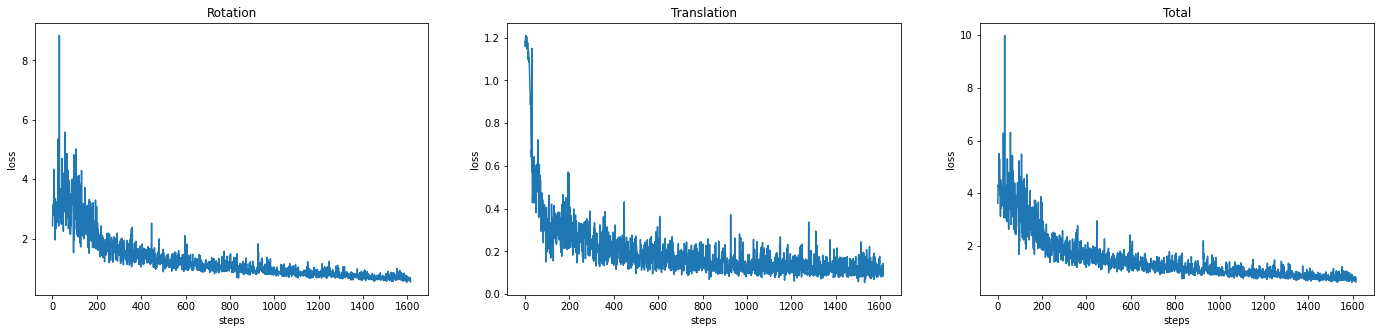

In [47]:
f, axes = plt.subplots(1, 3, figsize=[24, 5])

axes[0].plot(train_losses['rot_loss'])
axes[0].set_xlabel('steps')
axes[0].set_ylabel('loss')
axes[0].set_title('Rotation')

axes[1].plot(train_losses['trans_loss'])
axes[1].set_xlabel('steps')
axes[1].set_ylabel('loss')
axes[1].set_title('Translation')

axes[2].plot(train_losses['total_loss'])
axes[2].set_xlabel('steps')
axes[2].set_ylabel('loss')
axes[2].set_title('Total')

In [32]:
# Save checkpoint
ckpt_dir = './pkl_jar/jup_ckpt/'
ckpt_path = os.path.join(ckpt_dir, 'test.pkl')
du.write_checkpoint(
    ckpt_path, exp.model.state_dict(), exp._conf)

Serializing experiment state to ./pkl_jar/jup_ckpt/test.pkl


## Data visualization

In [40]:
train_iter = iter(train_loader)
next_item = next(train_iter)
print(next_item['t'])

tensor([0.0010, 0.6436, 0.8444, 0.2169, 0.9749, 0.4327, 0.6486, 0.5482, 0.3675,
        0.5984, 0.2169, 0.9598, 1.0000, 0.1014, 0.0412, 0.8243],
       dtype=torch.float64)


In [11]:
# Rigid process function
scale_factor = conf.data.rosetta.scale_factor
bb_mask = next_item['res_mask'].bool()
def process_rigids(rigids, b_idx):
    np_rigids = du.move_to_np(rigids[b_idx][bb_mask[b_idx]])
    se3_vec = au.rigids_to_se3_vec(np_rigids, scale_factor=scale_factor)
    return np_rigids, se3_vec

In [12]:
# Visualize example
b_idx = 0
rigids_t, noisy_se3_vec = process_rigids(next_item['rigids_t'], b_idx)
rigids_0, gt_se3_vec = process_rigids(next_item['rigids_0'], b_idx)


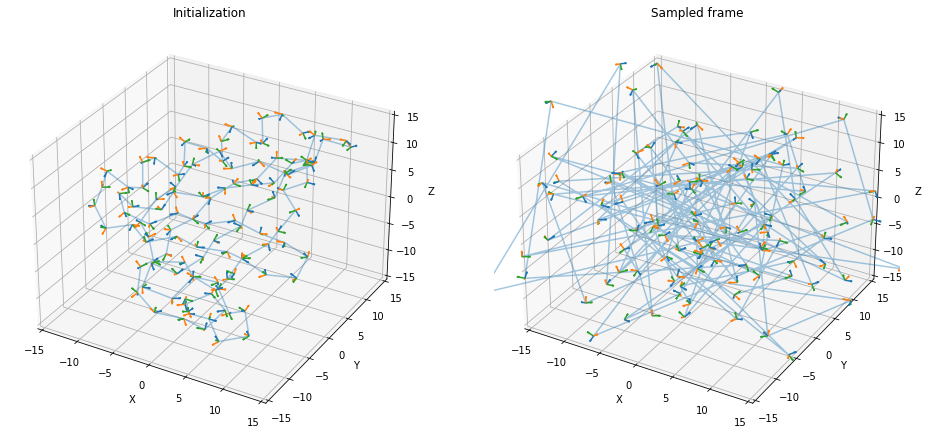

In [13]:
ax_lim = 15
f, axes = plt.subplots(1, 2, figsize=[16, 8], subplot_kw=dict(projection="3d"))
plotting.plot_se3(gt_se3_vec, ax=axes[0], title='Initialization', ax_lim=ax_lim)
plotting.plot_se3(noisy_se3_vec, ax=axes[1], title='Sampled frame', ax_lim=ax_lim)

## Sampling

In [10]:
# Load previously trained checkpoint
ckpt_dir = './pkl_jar/jup_ckpt/'
ckpt_path = os.path.join(ckpt_dir, 'test.pkl')

if len(os.listdir(ckpt_dir)) != 1:
    raise ValueError(f'Ambiguous ckpt in {ckpt_dir}')
ckpt_path = os.path.join(
    ckpt_dir, os.listdir(ckpt_dir)[0])
print(ckpt_path)
ckpt_pkl = du.read_pkl(ckpt_path)
ckpt_conf = ckpt_pkl['conf']
ckpt_model = ckpt_pkl['model']
exp.model.load_state_dict(ckpt_model)

./pkl_jar/jup_ckpt/test.pkl


<All keys matched successfully>

In [33]:
# Sample data point to initializez.
data_iter = iter(train_loader)
raw_data_feats = next(data_iter)

In [34]:
# Preprocess init data
exp_diffuser = exp.diffuser
batch_idx = 0
data_feats = tree.map_structure(lambda x: x[batch_idx], raw_data_feats)
res_mask = data_feats['res_mask']
res_idx = data_feats['res_idx']
rigids_0 = data_feats['rigids_0']

rigids_0 = rigids_0[torch.where(res_mask.bool())]
res_mask = res_mask[torch.where(res_mask.bool())]

num_res = res_mask.shape[0]
rigids_init = exp_diffuser.sample_ref(
    num_res,
    impute=ru.Rigid.from_tensor_7(rigids_0)
).to_tensor_7()
rigids_init *= res_mask[:, None]
init_feats = {
    'rigids_t': rigids_init,
    'res_mask': res_mask,
    'res_idx': res_idx,
    'res_idx': res_idx[torch.where(res_mask.bool())],
    't': torch.tensor(1.0),
    'rot_score_norm': data_feats['rot_score_norm'],
    'trans_score_norm': data_feats['trans_score_norm'],
}

num_res = res_mask.shape[0]
init_feats = tree.map_structure(lambda x: x[None].to(device), init_feats)
print(f'Sample length {torch.sum(res_mask)}')

Sample length 110


In [35]:
# Run inference
infer_out = exp.inference_fn(init_feats,num_t=500, add_noise=True)
sample_rigids = infer_out[0]

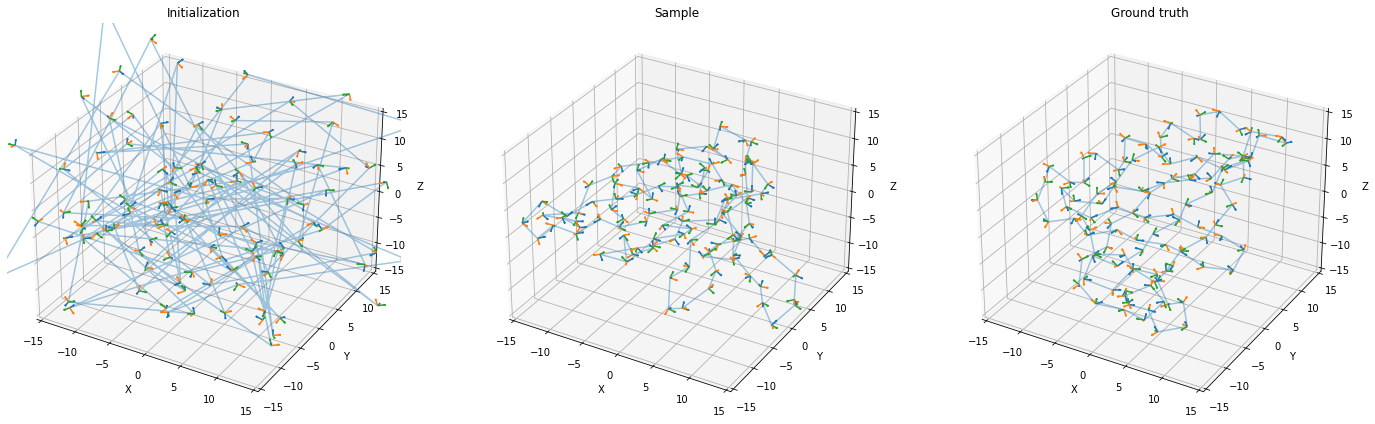

In [36]:
# Plot out SE(3)
final_rigid = sample_rigids[-2][0]
f, axes = plt.subplots(1, 3, figsize=[24, 8], subplot_kw=dict(projection="3d"))
scale_factor = conf.data.digs.scale_factor
ax_lim = 15.
plotting.viz_frames(init_feats['rigids_t'][0], res_mask, axes[0], title='Initialization', scale_factor=scale_factor, ax_lim=ax_lim)
plotting.viz_frames(final_rigid, res_mask, axes[1], title='Sample', scale_factor=scale_factor, ax_lim=ax_lim)
plotting.viz_frames(rigids_0, res_mask, axes[2], title='Ground truth', scale_factor=scale_factor, ax_lim=ax_lim)

In [37]:
# Calculate FAPE and Ca-RMSD metrics.
fape_loss = loss.rigids_fape(
    final_rigid,
    rigids_0.to(device),
    res_mask.to(device),
    length_scale=scale_factor)
rmsd_loss, aligned_pred_ca, gt_ca, align_rot_mat, align_trans, reflection = loss.rigids_ca_rmsd(
    final_rigid,
    rigids_0.to(device),
    res_mask.to(device),
    length_scale=scale_factor,
    return_align=True)
align_rot_euler = Rotation.from_matrix(align_rot_mat).as_euler('xyz', degrees=True)
print(f'FAPE: {fape_loss:2.4f}\nCa-RMSD: {rmsd_loss:2.4f}')
print(f'Alignment rotation: {align_rot_euler}\nAlignment translation: {align_trans[:,0]}\nAlignment reflection: {reflection}')


FAPE: 0.2182
Ca-RMSD: 8.4244
Alignment rotation: [ 11.12543916  56.85646033 169.02847185]
Alignment translation: [-3.5558323e-08  1.8052445e-07  1.0860138e-07]
Alignment reflection: False


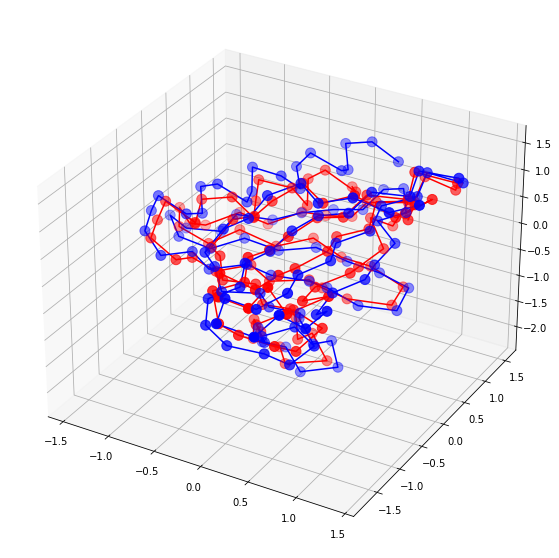

In [38]:
# Visualize aligned Ca structures
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

plotting.plt_3d(aligned_pred_ca, ax, color='r', s=100, mode='scatter')
plotting.plt_3d(aligned_pred_ca, ax, color='r', mode='line')
plotting.plt_3d(gt_ca, ax, color='b', s=100, mode='scatter')
plotting.plt_3d(gt_ca, ax, color='b', mode='line')

INFO: Animation.save using <class 'matplotlib.animation.PillowWriter'>


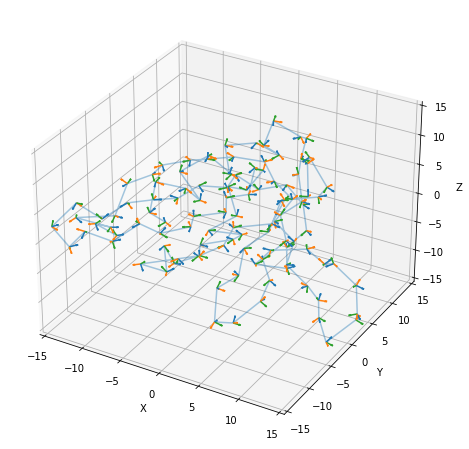

In [39]:
# Save trajectory as a gif
save_path = 'dev_diffusion_linear.gif'
sample_traj = torch.stack(sample_rigids)[:, 0]
ax_lim = 15
plotting.write_traj(
    sample_traj, res_mask, save_path, ax_lim=ax_lim, scale_factor=scale_factor
)